# Coursework 2 for Cardiac MR Image Segmentation (2020-2021)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

In [ ]:

#import torch

#if torch.cuda.is_available():       
#    device = torch.device("cuda")
#    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
#    print('Device name:', torch.cuda.get_device_name(0))

#else:
 #   print('No GPU available, using the CPU instead.')
  #  device = torch.device("cpu")


There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install torch
#!pip install -u numpy



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


## 1. Load, show, and save images with OpenCV

> Indented block



OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [ ]:
#!unzip CW2.zip

unzip:  cannot find or open CW2.zip, CW2.zip.zip or CW2.zip.ZIP.


In [1]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

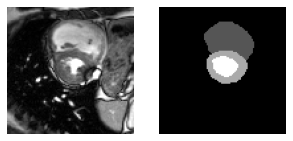

True

In [2]:
import os
import cv2 #import OpenCV

data_dir = './data/train' #'./data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr100.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr100_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr100.png'), mask*1)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [3]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module
from torch.nn import Sequential
from torch.nn import Conv2d, Dropout2d, MaxPool2d, ReLU, UpsamplingNearest2d

import torchvision.models as models

vgg16_dims = [
                    (64, 64, 'M'),                                # Stage - 1
                    (128, 128, 'M'),                              # Stage - 2
                    (256, 256, 256,'M'),                          # Stage - 3
                    (512, 512, 512, 'M'),                         # Stage - 4
                    (512, 512, 512, 'M')                          # Stage - 5
            ]
decoder_dims = [
                    ('U', 512, 512, 512),                         # Stage - 5
                    ('U', 512, 512, 512),                         # Stage - 4
                    ('U', 256, 256, 256),                         # Stage - 3
                    ('U', 128, 128),                              # Stage - 2
                    ('U', 64, 64)                                 # Stage - 1
                ]

class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()

        self.input_channels = 1
        self.output_channels = 4
        self.num_channels = 1
        self.vgg16 = models.vgg16(pretrained=True)

        # Encoder layers
        self.encoder_conv_00 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=self.input_channels, 
                                                          out_channels=64, 
                                                          kernel_size=3, 
                                                          padding=1), 
                                               nn.BatchNorm2d(64)])                                         
        self.encoder_conv_01 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=64,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(64)
                                                ])
        self.encoder_conv_10 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=64,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(128)
                                                ])
        self.encoder_conv_11 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(128)
                                                ])
        self.encoder_conv_20 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_21 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_22 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_30 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_31 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_32 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_40 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_41 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_42 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.init_vgg_weigts()

        # Decoder layers
        self.decoder_convtr_42 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_41 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_40 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_32 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_31 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_30 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_22 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_21 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_20 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=128,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(128)
                                               ])
        self.decoder_convtr_11 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=128,
                                                                   out_channels=128,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(128)
                                               ])
        self.decoder_convtr_10 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=128,
                                                                   out_channels=64,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(64)
                                               ])
        self.decoder_convtr_01 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=64,
                                                                   out_channels=64,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(64)
                                               ])
        self.decoder_convtr_00 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=64,
                                                                   out_channels=self.output_channels,
                                                                   kernel_size=3,
                                                                   padding=1)
                                               ])


    def forward(self, input_img):
        """
        Forward pass `input_img` through the network
        """
        # Encoder
        # Encoder Stage - 1
        dim_0 = input_img.size()
        x_00 = F.relu(self.encoder_conv_00(input_img))
        x_01 = F.relu(self.encoder_conv_01(x_00))
        x_0, indices_0 = F.max_pool2d(x_01, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 2
        dim_1 = x_0.size()
        x_10 = F.relu(self.encoder_conv_10(x_0))
        x_11 = F.relu(self.encoder_conv_11(x_10))
        x_1, indices_1 = F.max_pool2d(x_11, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 3
        dim_2 = x_1.size()
        x_20 = F.relu(self.encoder_conv_20(x_1))
        x_21 = F.relu(self.encoder_conv_21(x_20))
        x_22 = F.relu(self.encoder_conv_22(x_21))
        x_2, indices_2 = F.max_pool2d(x_22, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 4
        dim_3 = x_2.size()
        x_30 = F.relu(self.encoder_conv_30(x_2))
        x_31 = F.relu(self.encoder_conv_31(x_30))
        x_32 = F.relu(self.encoder_conv_32(x_31))
        x_3, indices_3 = F.max_pool2d(x_32, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 5
        dim_4 = x_3.size()
        x_40 = F.relu(self.encoder_conv_40(x_3))
        x_41 = F.relu(self.encoder_conv_41(x_40))
        x_42 = F.relu(self.encoder_conv_42(x_41))
        x_4, indices_4 = F.max_pool2d(x_42, kernel_size=2, stride=2, return_indices=True)

        # Decoder

        dim_d = x_4.size()

        # Decoder Stage - 5
        x_4d = F.max_unpool2d(x_4, indices_4, kernel_size=2, stride=2, output_size=dim_4)
        x_42d = F.relu(self.decoder_convtr_42(x_4d))
        x_41d = F.relu(self.decoder_convtr_41(x_42d))
        x_40d = F.relu(self.decoder_convtr_40(x_41d))
        dim_4d = x_40d.size()

        # Decoder Stage - 4
        x_3d = F.max_unpool2d(x_40d, indices_3, kernel_size=2, stride=2, output_size=dim_3)
        x_32d = F.relu(self.decoder_convtr_32(x_3d))
        x_31d = F.relu(self.decoder_convtr_31(x_32d))
        x_30d = F.relu(self.decoder_convtr_30(x_31d))
        dim_3d = x_30d.size()

        # Decoder Stage - 3
        x_2d = F.max_unpool2d(x_30d, indices_2, kernel_size=2, stride=2, output_size=dim_2)
        x_22d = F.relu(self.decoder_convtr_22(x_2d))
        x_21d = F.relu(self.decoder_convtr_21(x_22d))
        x_20d = F.relu(self.decoder_convtr_20(x_21d))
        dim_2d = x_20d.size()

        # Decoder Stage - 2
        x_1d = F.max_unpool2d(x_20d, indices_1, kernel_size=2, stride=2, output_size=dim_1)
        x_11d = F.relu(self.decoder_convtr_11(x_1d))
        x_10d = F.relu(self.decoder_convtr_10(x_11d))
        dim_1d = x_10d.size()

        # Decoder Stage - 1
        x_0d = F.max_unpool2d(x_10d, indices_0, kernel_size=2, stride=2, output_size=dim_0)
        x_01d = F.relu(self.decoder_convtr_01(x_0d))
        x_00d = self.decoder_convtr_00(x_01d)
        dim_0d = x_00d.size()
        return x_00d
        #x_softmax = F.softmax(x_00d, dim=1)
        #return x_00d, x_softmax

    def init_vgg_weigts(self):
        #assert self.encoder_conv_00[0].weight.size() == self.vgg16.features[0].weight.size()
        self.encoder_conv_00[0].weight.data = self.vgg16.features[0].weight.data
        #assert self.encoder_conv_00[0].bias.size() == self.vgg16.features[0].bias.size()
        self.encoder_conv_00[0].bias.data = self.vgg16.features[0].bias.data

        #assert self.encoder_conv_01[0].weight.size() == self.vgg16.features[2].weight.size()
        self.encoder_conv_01[0].weight.data = self.vgg16.features[2].weight.data
        #assert self.encoder_conv_01[0].bias.size() == self.vgg16.features[2].bias.size()
        self.encoder_conv_01[0].bias.data = self.vgg16.features[2].bias.data

        #assert self.encoder_conv_10[0].weight.size() == self.vgg16.features[5].weight.size()
        self.encoder_conv_10[0].weight.data = self.vgg16.features[5].weight.data
        #assert self.encoder_conv_10[0].bias.size() == self.vgg16.features[5].bias.size()
        self.encoder_conv_10[0].bias.data = self.vgg16.features[5].bias.data

        #assert self.encoder_conv_11[0].weight.size() == self.vgg16.features[7].weight.size()
        self.encoder_conv_11[0].weight.data = self.vgg16.features[7].weight.data
        #assert self.encoder_conv_11[0].bias.size() == self.vgg16.features[7].bias.size()
        self.encoder_conv_11[0].bias.data = self.vgg16.features[7].bias.data

        #assert self.encoder_conv_20[0].weight.size() == self.vgg16.features[10].weight.size()
        self.encoder_conv_20[0].weight.data = self.vgg16.features[10].weight.data
        #assert self.encoder_conv_20[0].bias.size() == self.vgg16.features[10].bias.size()
        self.encoder_conv_20[0].bias.data = self.vgg16.features[10].bias.data

        #assert self.encoder_conv_21[0].weight.size() == self.vgg16.features[12].weight.size()
        self.encoder_conv_21[0].weight.data = self.vgg16.features[12].weight.data
        #assert self.encoder_conv_21[0].bias.size() == self.vgg16.features[12].bias.size()
        self.encoder_conv_21[0].bias.data = self.vgg16.features[12].bias.data

        #assert self.encoder_conv_22[0].weight.size() == self.vgg16.features[14].weight.size()
        self.encoder_conv_22[0].weight.data = self.vgg16.features[14].weight.data
        #assert self.encoder_conv_22[0].bias.size() == self.vgg16.features[14].bias.size()
        self.encoder_conv_22[0].bias.data = self.vgg16.features[14].bias.data

        #assert self.encoder_conv_30[0].weight.size() == self.vgg16.features[17].weight.size()
        self.encoder_conv_30[0].weight.data = self.vgg16.features[17].weight.data
        #assert self.encoder_conv_30[0].bias.size() == self.vgg16.features[17].bias.size()
        self.encoder_conv_30[0].bias.data = self.vgg16.features[17].bias.data

        #assert self.encoder_conv_31[0].weight.size() == self.vgg16.features[19].weight.size()
        self.encoder_conv_31[0].weight.data = self.vgg16.features[19].weight.data
        #assert self.encoder_conv_31[0].bias.size() == self.vgg16.features[19].bias.size()
        self.encoder_conv_31[0].bias.data = self.vgg16.features[19].bias.data

        #assert self.encoder_conv_32[0].weight.size() == self.vgg16.features[21].weight.size()
        self.encoder_conv_32[0].weight.data = self.vgg16.features[21].weight.data
        #assert self.encoder_conv_32[0].bias.size() == self.vgg16.features[21].bias.size()
        self.encoder_conv_32[0].bias.data = self.vgg16.features[21].bias.data

        #assert self.encoder_conv_40[0].weight.size() == self.vgg16.features[24].weight.size()
        self.encoder_conv_40[0].weight.data = self.vgg16.features[24].weight.data
        #assert self.encoder_conv_40[0].bias.size() == self.vgg16.features[24].bias.size()
        self.encoder_conv_40[0].bias.data = self.vgg16.features[24].bias.data

        #assert self.encoder_conv_41[0].weight.size() == self.vgg16.features[26].weight.size()
        self.encoder_conv_41[0].weight.data = self.vgg16.features[26].weight.data
        #assert self.encoder_conv_41[0].bias.size() == self.vgg16.features[26].bias.size()
        self.encoder_conv_41[0].bias.data = self.vgg16.features[26].bias.data

        #assert self.encoder_conv_42[0].weight.size() == self.vgg16.features[28].weight.size()
        self.encoder_conv_42[0].weight.data = self.vgg16.features[28].weight.data
        #assert self.encoder_conv_42[0].bias.size() == self.vgg16.features[28].bias.size()
        self.encoder_conv_42[0].bias.data = self.vgg16.features[28].bias.data

model = SegNet() # We can now create a model using your defined segmentation model

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

In [5]:
Loss = nn.CrossEntropyLoss() 
#Loss=  torch.nn.HingeEmbeddingLoss()    - Hinge Embedding
#Loss= torch.nn.KLDivLoss() - Kullback-Leibler divergence
#Loss = torch.nn.NLLLoss()
#Loss = torch.nn.MSELoss()
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
#optimiser = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
#optimiser=torch.optim.SparseAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
#optimiser=torch.optim.SGD(model.parameters(), lr=0.1, momentum=0, dampening=0, weight_decay=0, nesterov=False)
#optimiser= torch.optim.LBFGS(params, lr=1, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn=None)

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [8]:
from torch.utils.data import DataLoader
import numpy as np

def closure():
  optimizer.zero_grad()
  # Forward pass
        #outputs = model(torch.reshape(img[None, ...],(batch_size,1,96,96)))
  outputs = model(img.unsqueeze(1))
  loss = Loss(outputs, mask.long())
  # Then write your BACKWARD & OPTIMIZE below
        # Note: Compute Loss and Optimize
        # Backward and optimize
  loss.backward()
  return loss
    
data_path_train = './data/train'
num_workers = 4
batch_size = 10 #5
train_set = TrainDataset(data_path_train)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
data_path_val = './data/val'
eval_set = TrainDataset(data_path_val)
eval_data_loader = DataLoader(dataset=eval_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
epochs = 10 #10
running_loss_eval_log=[]
for epoch in range(epochs):
    running_loss_train=0
    running_loss_eval=0
    # Fetch images and labels.
    model.train()
    for iteration, sample in enumerate(training_data_loader):

        img, mask = sample
        #show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze()) #visualise all data in training set
        plt.pause(1)
        optimizer.zero_grad()
        # Write your FORWARD below
        # Note: Input image to your model and ouput the predicted mask and Your predicted mask should have 4 channels
        # Forward pass
        #outputs = model(torch.reshape(img[None, ...],(batch_size,1,96,96)))


        img = img.unsqueeze(1).repeat(1, 3, 1, 1) #Did this to get input in RGB format, I am going to try and remove this
        #print(img.size())
        outputs = model(img)
        print("output size:", outputs.size())


        #print(mask.long().size())
        loss = Loss(outputs, mask.long())
        # Then write your BACKWARD & OPTIMIZE below
        # Note: Compute Loss and Optimize
        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
        if iteration==(100/batch_size-1):    # print every 2000 mini-batches
            print('[%d] training loss: %.3f' %
                  (epoch + 1, running_loss_train / (100/batch_size)))
            running_loss_train = 0.0
        
        #a = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
        #print(np.unique(a))
        #show_image_mask(a, mask[0,...].squeeze())
        
        plt.pause(1)

    #evaluate the data
    model.eval()
    # Fetch images and labels.  
    for iteration, sample in enumerate(eval_data_loader):
        with torch.no_grad():
            img, mask = sample
            #show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze()) #visualise all data in training set
            plt.pause(1)
            # Write your FORWARD below
            # Note: Input image to your model and ouput the predicted mask and Your predicted mask should have 4 channels
            # Forward pass


            img = img.unsqueeze(1).repeat(1, 3, 1, 1) #Did this to get input in RGB format, I am going to try and remove this
            outputs = model(img)
            loss = Loss(outputs, mask.long())
            print("output size:", outputs.size())


            #print(mask.size())
            running_loss_eval += loss.item()
            if iteration==(20/batch_size-1):    # print every 2000 mini-batches
                print('validation loss: %.6f' %
                  (running_loss_eval / (20/batch_size)))
                #np.append(running_loss_eval_log,running_loss_eval / (20/batch_size))
                running_loss_eval_log.append(running_loss_eval / (20/batch_size))
                running_loss_eval = 0.0
    #early stopping - think this is faulty
    #if epoch>=3:
    #   if (running_loss_eval_log[epoch]>running_loss_eval_log[epoch-3] and running_loss_eval_log[epoch]>running_loss_eval_log[epoch-2] and running_loss_eval_log[epoch]>running_loss_eval_log[epoch-1]):
    #        break
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)
print(running_loss_eval_log)

output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
[1] training loss: 0.944
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
validation loss: 1.041850
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
output size: torch.Size([10, 4, 96, 96])
[2] training loss: 0.406
output size: torch.Siz

KeyboardInterrupt: 

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [ ]:
import numpy as np
from torch.autograd import Variable

In [ ]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
data_path = './data/test'
num_workers = 4
batch_size = 1
PATH = './cifar_net.pth'
test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)
model.load_state_dict(torch.load(PATH))
model.eval()
i=121 #120
for iteration, sample in enumerate(test_data_loader):
    with torch.no_grad():
        img = sample
        view_img = img


        img = img.unsqueeze(1).repeat(1, 3, 1, 1) #Did this to get input in RGB format, I am going to try and remove this
        mask=model(img)    
        #img = torch.mean(img, 0)
        mask = torch.argmax(mask.squeeze(), dim=0).detach().cpu().numpy()  


        #print(np.unique(img1))
        #a = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
        #print(np.unique(a))
        #show_image_mask(a, mask[0,...].squeeze())
        # plt.imshow(img1[0,...].squeeze(), cmap='gray') #visualise all images in test set
        imagename="cmr"+str(i)+"_mask.png"
        data_dir = './data/test/mask' #'./data/test'
        print(i)
        show_image_mask(view_img[0,...].squeeze(), mask, cmap='gray')
        plt.pause(1)
        cv2.imwrite(os.path.join(data_dir,'./',imagename),mask)
        i =i+1
        
#categorical_dice()        


In [ ]:
data_dir = './data/test' #'./data/test'
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr100.png'), mask*85)

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [ ]:
def categorical_dice(mask1, mask2, label_class):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()

In [ ]:
submission_converter('./data/test/mask','./submission')

#Report


## Introduction
(10\%): discuss the data sets involved, the machine learning task,
relevant work and what you aimed to achieve.

We are trying to produce masks that are semantic segmentations of magnetic resonance images using deep learning. The dataset we are working on contains 200 CMR images, 50% for training, 10% for validation and 40% for testing.  We have selected and inplemented a network architecture (U-net), trained the network and have tuned the hyperparameters to yield the best classification accuracy. Our aims was to do well in the Kaggle leaderboards.
We started with working on finding a suitable CNN architecture. We then implemented what we found from our source and modified it to suit our problem. Then we assigned team members differeing sets of hyperparameters to experiment with whilst training the network. We then tuned our hyperparameters from our results and submitted our results to Kaggle.


## Implementation
(35\%): describe how you implemented your neural network and the associated performance analysis mechanisms. Explain why you chose to do it that way. Remember to cite any sources you used.

As for selecting potential CNN architecures for the segmentation network, we were considering FCN2, DeepLab3, SegNet and U-net.  

The convolutional neural network architecture that we have chosen to use is U-net. ***The version we have used is a mini-network of U-net as our training data is small?*** We found an existing architecture implementation at this website: https://towardsdatascience.com/train-a-lines-segmentation-model-using-pytorch-34d4adab8296. We then modified the code to suit our problem.

(If we have time we can experiment with a few other CNN architectures.)

For Loss functions we decided on:
To obtain precise segmentation results, implementing an effective loss funciotn is important. Some loss functions we considered were : the cross entropy loss6, the soft dice loss7, the focal loss8, the boundary loss9, or a combination of some of them.
For optimzers we used:

## Experiment
(40\%): describe the experiments you carried out to optimize your
network’s generalization performance and present the results you obtained. Explain in detail how you used the training, validation and test data sets. The results should be presented in a statistically rigorous manner.

For training, you are expected to show the following components: network architecture, loss fucniton, optimizer and training processing. For the training process, you should show you understanding on the number of epochs required to train you network, as well as data loading, It is also necessary to show correct training mode (model.train), zero gradient (optimizer.zero grad), backpropagation (loss.backward), optimization (optimizer.step), etc.




## Conclusion
(10\%): summarize your key findings, including which factors proved most crucial, and what was the best generalization performance you achieved.

## References

(1) Mostafa Gazar (Sep 14, 2019) Train a lines segmentation model using Pytorch. Available at https://towardsdatascience.com/train-a-lines-segmentation-model-using-pytorch-34d4adab8296

(2) Olaf Ronneberger, Philipp Fischer, and Thomas Brox (May 18, 2015) U-Net: Convolutional Networks for Biomedical Image Segmentation. Available at https://arxiv.org/pdf/1505.04597.pdf

